In [20]:
%%file dataset.py
# Generate training dataset and test dataset.
from constant import *
import os
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import copy
import random
import time
import argparse

#### Parameters. ####
parser = argparse.ArgumentParser()
parser.add_argument('--dataset_index', required=True)
parser.add_argument('--type_str', required=True)
args = parser.parse_args()

#type_str = '1k_nocrop_obj' # {1k_}[crop | nocrop | crop_obj | nocrop_obj | aperture]
type_str = args.type_str

#dataset = [(0.0, 0), (1.0/4, 4), (1.0/3, 3), (1.0/2, 3), (2.0/3, 3), (4.0/5, 3), (9.0/10, 3), (1.0, 1)]
#dataset = [(0.0, 0), (0.1, 10), (0.2, 5), (0.3, 4), (0.4, 3), (0.5, 3), (0.6, 3), (0.7, 3), (0.8, 3), (0.9, 3), (1.0, 1)]
dataset = [(0.0, 0), (0.2, 9), (0.4, 9), (0.6, 9), (0.8, 9), (1.0, 9)] # when crop_obj or nocrop_obj, (size, total_num)
dataset = [dataset[int(args.dataset_index)]]
print 'Processsing dataset {}, type_str {}'.format(dataset[0], type_str)

# divide to training dataset and test dataset
training_dataset_size = 100
test_dataset_size = 50

# obj image: always 1024 * 768 pixels
obj_width = 1024
obj_height = 768
obj_ratio = float(obj_width) / obj_height
#####################

# Load labels.
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
label_to_wnid = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
wnid_to_label = {}
for label in range(len(label_to_wnid)):
    wnid = label_to_wnid[label].split(' ')[0]
    wnid_to_label[wnid] = label

training_dataset = dataset
test_dataset = dataset

train_folders = []
test_folders = []
train_files = []
test_files = []

for (slider_size, slider_num) in training_dataset:
    percent = str(int(100 * slider_size))
    f = open('{}dataset/train_{}_{}.txt'.format(imagenet_root, type_str, percent), 'w')
    train_files.append(f)
    
    folder = '{}dataset/train_{}_{}/'.format(imagenet_root, type_str, percent)
    if not os.path.exists(folder):
        os.makedirs(folder)
    train_folders.append(folder)
        

for (slider_size, slider_num) in test_dataset:
    percent = str(int(100 * slider_size))
    f = open('{}dataset/test_{}_{}.txt'.format(imagenet_root, type_str, percent), 'w')
    test_files.append(f)

    folder = '{}dataset/test_{}_{}/'.format(imagenet_root, type_str, percent)
    if not os.path.exists(folder):
        os.makedirs(folder)
    test_folders.append(folder)
    
if 'obj' in type_str:
    obj_images = []
    for i, image_name in enumerate(os.listdir(shapenet_root + 'object_nobg/')):
        img_temp = Image.open(shapenet_root + 'object_nobg/' + image_name)
        img = img_temp.copy()
        img_temp.close()
        #img = img.convert("RGBA")
        obj_images.append(img)
print "{} object occluders loaded.".format(len(obj_images))

# occluder size = slider_size * slider_size
# occluder num = slider_num * slider_num
# path = 'imagenet_root/dataset/train_0/name'
# {wnid_imgid}_{crop/nocrop}_{rect_i(ifcrop)}_{slider_size}_{i}_{j}
def generate_datum(img_orig, path, f, class_id, rects, slider_size, slider_num):
    if type_str == 'crop' or type_str == '1k_crop':
        if slider_size == 0:
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                img = img.crop(rect)
                datum_path = '{}_{}_{}_0_0_0.jpeg'.format(path, type_str, rect_i)
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for rect_i, rect in enumerate(rects):
                for i in range(slider_num):
                    for j in range(slider_num):
                        img = img_orig.copy()
                        d = ImageDraw.Draw(img)
                        if (slider_num == 1):
                            delta = 1
                        else:
                            delta = (1 - slider_size) / float(slider_num - 1)
                        subrect = [0, 0, 0, 0]
                        subrect[0] = rect[0] + i * (rect[2] - rect[0]) * delta
                        subrect[1] = rect[1] + j * (rect[3] - rect[1]) * delta
                        subrect[2] = subrect[0] + (rect[2] - rect[0]) * slider_size
                        subrect[3] = subrect[1] + (rect[3] - rect[1]) * slider_size
                        d.rectangle(subrect, fill="black", outline=None)
                        img = img.crop(rect)
                        datum_path = '{}_{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)), str(i), str(j))
                        img.save(datum_path)
                        f.write('{} {}\n'.format(datum_path, str(class_id)))
    if type_str == 'nocrop' or type_str == '1k_nocrop':
        if slider_size == 0:
            datum_path = '{}_{}_0_0_0_0.jpeg'.format(path, type_str)
            img_orig.save(datum_path)
            f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for i in range(slider_num):
                for j in range(slider_num):
                    img = img_orig.copy()
                    d = ImageDraw.Draw(img)
                    if (slider_num == 1):
                        delta = 1
                    else:
                        delta = (1 - slider_size) / float(slider_num - 1)
                    for rect in rects:
                        subrect = [0, 0, 0, 0]
                        subrect[0] = rect[0] + i * (rect[2] - rect[0]) * delta
                        subrect[1] = rect[1] + j * (rect[3] - rect[1]) * delta
                        subrect[2] = subrect[0] + (rect[2] - rect[0]) * slider_size
                        subrect[3] = subrect[1] + (rect[3] - rect[1]) * slider_size
                        d.rectangle(subrect, fill="black", outline=None)
                    datum_path = '{}_{}_{}_{}_{}_{}.jpeg'.format(path, type_str, 0, str(int(100 * slider_size)), str(i), str(j))
                    img.save(datum_path)
                    f.write('{} {}\n'.format(datum_path, str(class_id)))                    
    
    if type_str == 'crop_obj' or type_str == '1k_crop_obj':
        if slider_size == 0:
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                img = img.crop(rect)
                datum_path = '{}_{}_{}_{}_0.jpeg'.format(path, type_str, rect_i, int(100 * slider_size))
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for rect_i, rect in enumerate(rects):
                for num in range(slider_num):
                    img = img_orig.copy()
                    random_obj = obj_images[random.randint(0, len(obj_images) - 1)].copy()
                    width = rect[2] - rect[0]
                    height = rect[3] - rect[1]
                    ratio = float(width) / height
                    if ratio >= obj_ratio:
                        resize_scale = float(height) / obj_height * slider_size
                    else:
                        resize_scale = float(width) / obj_width * slider_size
                    new_width = int(obj_width * resize_scale)
                    new_height = int(obj_height * resize_scale)
                    if new_width == 0:
                        new_width = 1
                    if new_height == 0:
                        new_height = 1
                    random_obj = random_obj.resize((new_width, new_height), Image.ANTIALIAS)
                    
                    rangex = [rect[0], rect[2] - random_obj.size[0]]
                    if rangex[1] < rangex[0]:
                        rangex[1] = rangex[0]
                        
                    rangey = [rect[1], rect[3] - random_obj.size[1]]
                    if rangey[1] < rangey[0]:
                        rangey[1] = rangey[0]
                    top_left = (random.randint(rangex[0], rangex[1]), random.randint(rangey[0], rangey[1]))
                    img.paste(random_obj, top_left, random_obj)
                    img = img.crop(rect)
                    datum_path = '{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, int(100 * slider_size), num)
                    img.save(datum_path)
                    f.write('{} {}\n'.format(datum_path, str(class_id)))
                    
    if type_str == 'nocrop_obj' or type_str == '1k_nocrop_obj':
        if slider_size == 0:
            datum_path = '{}_{}_{}_{}_0.jpeg'.format(path, type_str, 0, int(100 * slider_size))
            img_orig.save(datum_path)
            f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for num in range(slider_num):
                img = img_orig.copy()
                for rect_i, rect in enumerate(rects):
                    random_obj = obj_images[random.randint(0, len(obj_images) - 1)].copy()
                    width = rect[2] - rect[0]
                    height = rect[3] - rect[1]
                    ratio = float(width) / height
                    if ratio >= obj_ratio:
                        resize_scale = float(height) / obj_height * slider_size
                    else:
                        resize_scale = float(width) / obj_width * slider_size
                    new_width = int(obj_width * resize_scale)
                    new_height = int(obj_height * resize_scale)
                    if new_width == 0:
                        new_width = 1
                    if new_height == 0:
                        new_height = 1
                    random_obj = random_obj.resize((new_width, new_height), Image.ANTIALIAS)
                    
                    rangex = [rect[0], rect[2] - random_obj.size[0]]
                    if rangex[1] < rangex[0]:
                        rangex[1] = rangex[0]
                        
                    rangey = [rect[1], rect[3] - random_obj.size[1]]
                    if rangey[1] < rangey[0]:
                        rangey[1] = rangey[0]
                    top_left = (random.randint(rangex[0], rangex[1]), random.randint(rangey[0], rangey[1]))
                    img.paste(random_obj, top_left, random_obj)
                    
                datum_path = '{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, int(100 * slider_size), num)
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))              
                    
                    
    if type_str == 'aperture' or type_str == '1k_aperture':
        if slider_size == 0: # All black.
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                d = ImageDraw.Draw(img)
                d.rectangle(rect, fill="black", outline=None)
                img = img.crop(rect)
                datum_path = '{}_{}_{}_{}_0_0.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)))
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        elif slider_size == 1: # All visible. 
            for rect_i, rect in enumerate(rects):
                img = img_orig.copy()
                img = img.crop(rect)
                datum_path = '{}_{}_{}_{}_0_0.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)))
                img.save(datum_path)
                f.write('{} {}\n'.format(datum_path, str(class_id)))
        else:
            for rect_i, rect in enumerate(rects):
                for i in range(slider_num):
                    for j in range(slider_num):
                        img = img_orig.copy()
                        d = ImageDraw.Draw(img)
                        delta = (1 - slider_size) / float(slider_num - 1)
                        subrect = [0, 0, 0, 0]
                        subrect[0] = rect[0] + i * (rect[2] - rect[0]) * delta
                        subrect[1] = rect[1] + j * (rect[3] - rect[1]) * delta
                        subrect[2] = subrect[0] + (rect[2] - rect[0]) * slider_size
                        subrect[3] = subrect[1] + (rect[3] - rect[1]) * slider_size
                        d.rectangle([0, 0, img.size[0], subrect[1]], fill="black", outline=None)
                        d.rectangle([0, 0, subrect[0], img.size[1]], fill="black", outline=None)
                        d.rectangle([subrect[2], 0, img.size[0], img.size[1]], fill="black", outline=None)
                        d.rectangle([0, subrect[3], img.size[0], img.size[1]], fill="black", outline=None)
                        img = img.crop(rect)
                        datum_path = '{}_{}_{}_{}_{}_{}.jpeg'.format(path, type_str, rect_i, str(int(100 * slider_size)), str(i), str(j))
                        img.save(datum_path)
                        f.write('{} {}\n'.format(datum_path, str(class_id)))
            
if '1k' in type_str:
    image_path = imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/'
    annotation_path =  imagenet_root + 'ILSVRC2015/Annotations/CLS-LOC/train/'
else:
    image_path = imagenet_root + 'image/'
    annotation_path = imagenet_root + 'Annotation/'

synset_names = os.listdir(image_path)
            
start_time = time.time()

dataset_sum = training_dataset_size + test_dataset_size
all_sum = len(synset_names) * dataset_sum
print all_sum
for synset_index, synset_name in enumerate(synset_names):
    image_names = os.listdir(image_path + synset_name)
    annotation_names = os.listdir(annotation_path + synset_name)
    n1 = [os.path.splitext(n)[0] for n in image_names]
    n2 = [os.path.splitext(n)[0] for n in annotation_names]
    intersection_names = list(set(n1) & set(n2))
    for i in range(dataset_sum):
        if (i + 1) % 50 == 0:
            second = int(time.time() - start_time)
            now_time = time.strftime("%H:%M:%S", time.gmtime(second))
            now_sum = synset_index * dataset_sum + i
            
            estimated = int(float(all_sum) / now_sum * second)
            estimated_time = time.strftime("%H:%M:%S", time.gmtime(estimated))
            estimated_day = estimated / 3600 / 24
            print '[{}/{} {}]Processing synset [{}/{}], image [{}/{}]: {}'.format(now_time, estimated_day, estimated_time, synset_index + 1, len(synset_names), i + 1, dataset_sum, intersection_names[i])
        # Read bounding box.
        bbx_file = open(annotation_path + synset_name + '/' + intersection_names[i] + '.xml')
        xmltree = ET.parse(bbx_file)
        objects = xmltree.findall('object')
        rects = []
        for obj in objects:
            bbx = obj.find('bndbox')
            rects.append([int(it.text) for it in bbx])
            
        img_orig = Image.open(image_path + synset_name + '/' + intersection_names[i] + '.JPEG')
        
        if '1k' in type_str:
            class_id = wnid_to_label[synset_name]
        else:
            class_id = original_to_new_class_id[wnid_to_label[synset_name]]
        
        if i < training_dataset_size: # Training dataset. 
            for index, (slider_size, slider_num) in enumerate(training_dataset):
                generate_datum(img_orig, '{}{}'.format(train_folders[index], intersection_names[i]), \
                               train_files[index], class_id, rects, slider_size, slider_num)
        else: # Testing dataset.
            for index, (slider_size, slider_num) in enumerate(test_dataset):
                generate_datum(img_orig, '{}{}'.format(test_folders[index], intersection_names[i]), \
                               test_files[index], class_id, rects, slider_size, slider_num)
            
for f in train_files:
    f.close()
for f in test_files:
    f.close()
            

Overwriting dataset.py


In [ ]:
# Sample.

import os
import random
from constant import *

need_samples = ['10', '20', '30']

type_str = 'aperture'
sample_sum = 62316

# train
'''
for need_sample in need_samples:
    os.rename('{}dataset/train_{}_{}.txt'.format(imagenet_root, type_str, need_sample), '{}dataset/train_{}_{}_unsampled.txt'.format(imagenet_root, type_str, need_sample))
    f = open('{}dataset/train_{}_{}_unsampled.txt'.format(imagenet_root, type_str, need_sample), 'r')
    lines = f.readlines()
    f.close()
    sampled = random.sample(lines, sample_sum)
    f = open('{}dataset/train_{}_{}.txt'.format(imagenet_root, type_str, need_sample), 'w')
    f.writelines(sampled)
    f.close()
'''
# test
for need_sample in need_samples:
    os.rename('{}dataset/test_{}_{}.txt'.format(imagenet_root, type_str, need_sample), '{}dataset/test_{}_{}_unsampled.txt'.format(imagenet_root, type_str, need_sample))
    f = open('{}dataset/test_{}_{}_unsampled.txt'.format(imagenet_root, type_str, need_sample), 'r')
    lines = f.readlines()
    f.close()
    sampled = random.sample(lines, 21168)
    f = open('{}dataset/test_{}_{}.txt'.format(imagenet_root, type_str, need_sample), 'w')
    f.writelines(sampled)
    f.close()


In [2]:
# Create all.
import os
import random
from constant import *

dataset = [(0.0, 0), (0.2, 9), (0.4, 9), (0.6, 9), (0.8, 9), (1.0, 9)] # when crop_obj or nocrop_obj, (size, total_num)

sample_sum = {'train': {'1k_crop_obj': 1016757, '1k_nocrop_obj': 900000}, \
              'test': {'1k_crop_obj': 509238, '1k_nocrop_obj': 450000}}

# train_{}_all
for type_str in ['1k_crop_obj', '1k_nocrop_obj']:
    for func_str in ['train', 'test']:
        lines = []
        for size, num in dataset:
            percent = int(size * 100)
            f = open('{}dataset/{}_{}_{}.txt'.format(imagenet_root, func_str, type_str, percent), 'r')
            ls = f.readlines()
            f.close()
            lines = lines + ls
        f = open('{}dataset/{}_{}_all_unsampled.txt'.format(imagenet_root, func_str, type_str), 'w')
        f.writelines(lines)
        f.close()
        
        
        sampled = random.sample(lines, sample_sum[func_str][type_str])
        f = open('{}dataset/{}_{}_all.txt'.format(imagenet_root, func_str, type_str), 'w')
        f.writelines(sampled)
        f.close()

In [18]:
#%%file transparent.py
# Make white color transparent.
from constant import *
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np
import os

image_names = os.listdir(shapenet_root + 'object_orig/')
print len(image_names)

for i, image_name in enumerate(image_names):
    print '[{}/{}]: {}'.format(i, len(image_names), image_name)
    img = Image.open(shapenet_root + 'object_orig/' + image_name)
    
    img = img.convert("RGBA")
    pixdata = img.load()
    for y in xrange(img.size[1]):
        for x in xrange(img.size[0]):
            if pixdata[x, y] == (255, 255, 255, 255):
                pixdata[x, y] = (255, 255, 255, 0)
    img.save(shapenet_root + 'object_nobg/' + image_name, 'PNG')


1000
[0/1000]: a36e1456c6d68281132a08135eefe76d-2.png
[1/1000]: be99f079debaeed9a0fa21f3ff15b515-2.png
[2/1000]: 1222c37fc0c37124824662341ce2b233-2.png
[3/1000]: 6628119d7cf6ca8b82db9fca4b68095-2.png
[4/1000]: f120085da70b2913627279ad10ae805a-2.png
[5/1000]: 4e007e41bad1b1cd735fa1ab17311ec-2.png
[6/1000]: 83e5b5a3f3aad942ed29cc2a32e4bbed-2.png
[7/1000]: 4707a1494196ef829917ad57402f53f1-2.png
[8/1000]: da12a5d96b465cf6bced73c51e99f8b2-2.png
[9/1000]: 8b4314a159d964fdcb2a965e75be701c-2.png
[10/1000]: fd63218d927ae58cbf444790f25ea3db-2.png
[11/1000]: 75432c09d6b34efd336e9e51cf4eee59-2.png
[12/1000]: 33d7cf0698dea49acaf9c991e0bc2cd-2.png
[13/1000]: 41f3ad2781ee196bad0e80a2288e336-2.png
[14/1000]: 675e25ef07ef717cc8bd7a04c9659f1-2.png
[15/1000]: ce8ec2504676cf874b3c42e318f3affc-2.png
[16/1000]: fec05c85454edafc4310636931b68fdb-2.png
[17/1000]: b65cbede8f483d51f7de4d28691515e1-2.png
[18/1000]: a48e359faed3da88d3519c62a8100783-2.png
[19/1000]: f42ef3273a8b4cbbf4f70c928a738b3-2.png
[20/1000]: 

In [ ]:
# Show typical images of each class.
from constant import *
import os
import numpy as np
#from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import copy
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import Image, display


imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
with open(imagenet_labels_filename) as f:
    lines = f.readlines()
wnid_to_name = {}
for line in lines:
    wnid = line.split(' ')[0]
    name = line[(len(wnid) + 1):-1]
    wnid_to_name[wnid] = name

synset_names = os.listdir(imagenet_root + 'image/')
for synset_name in synset_names:
    image_names = os.listdir(imagenet_root + 'image/' + synset_name + '/' + synset_name + '_original_images')
    print wnid_to_name[synset_name], 'http://image-net.org/synset?wnid=' + synset_name
    display(Image(filename=imagenet_root + 'image/' + synset_name + '/' + synset_name + '_original_images/' + image_names[42]))
    display(Image(filename=imagenet_root + 'image/' + synset_name + '/' + synset_name + '_original_images/' + image_names[32]))
    display(Image(filename=imagenet_root + 'image/' + synset_name + '/' + synset_name + '_original_images/' + image_names[22]))
    display(Image(filename=imagenet_root + 'image/' + synset_name + '/' + synset_name + '_original_images/' + image_names[12]))
    display(Image(filename=imagenet_root + 'image/' + synset_name + '/' + synset_name + '_original_images/' + image_names[0]))
    
    
    

In [10]:
# Sanity check.
import os
from constant import *

func_strs = ['train', 'test']
type_strs = ['1k_nocrop_obj', '1k_crop_obj']
dataset = [(0.0, 0), (0.2, 9), (0.4, 9), (0.6, 9), (0.8, 9), (1.0, 9)] # when crop_obj or nocrop_obj, (size, total_num)


for filename in sorted(os.listdir(imagenet_root + 'dataset/')):
    for func_str in func_strs:
        for type_str in type_strs:
            if '{}_{}'.format(func_str, type_str) in filename and '.txt' in filename:
                f = open(imagenet_root + 'dataset/' + filename)
                lines = f.readlines()
                print '{:10d} {}'.format(len(lines), filename)

     56582 test_1k_crop_obj_0.txt
    509238 test_1k_crop_obj_100.txt
    509238 test_1k_crop_obj_20.txt
    509238 test_1k_crop_obj_40.txt
    509238 test_1k_crop_obj_60.txt
    509238 test_1k_crop_obj_80.txt
    509238 test_1k_crop_obj_all.txt
   2602772 test_1k_crop_obj_all_unsampled.txt
     50000 test_1k_nocrop_obj_0.txt
    450000 test_1k_nocrop_obj_100.txt
    450000 test_1k_nocrop_obj_20.txt
    450000 test_1k_nocrop_obj_40.txt
    450000 test_1k_nocrop_obj_60.txt
    450000 test_1k_nocrop_obj_80.txt
    450000 test_1k_nocrop_obj_all.txt
   2300000 test_1k_nocrop_obj_all_unsampled.txt
    112973 train_1k_crop_obj_0.txt
   1016757 train_1k_crop_obj_100.txt
   1016757 train_1k_crop_obj_20.txt
   1016757 train_1k_crop_obj_40.txt
   1016757 train_1k_crop_obj_60.txt
   1016757 train_1k_crop_obj_80.txt
   1016757 train_1k_crop_obj_all.txt
   5196758 train_1k_crop_obj_all_unsampled.txt
    100000 train_1k_nocrop_obj_0.txt
    900000 train_1k_nocrop_obj_100.txt
    900000 train_1k_nocr

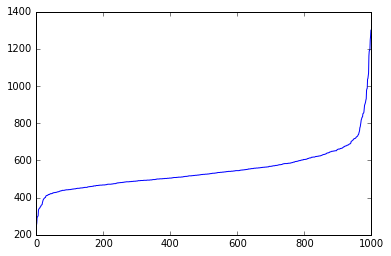

In [1]:
import os
from constant import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = open(caffe_root + 'data/ilsvrc12/synset_words.txt')
label_to_wnid = f.readlines()
wnid_to_label = {}
for label in range(len(label_to_wnid)):
    wnid = label_to_wnid[label].split(' ')[0]
    wnid_to_label[wnid] = label

folders = os.listdir(imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/')
count = []
for folder in folders:
    image_names = os.listdir(imagenet_root + 'ILSVRC2015/Data/CLS-LOC/train/' + folder)
    annotation_names = os.listdir(imagenet_root + 'ILSVRC2015/Annotations/CLS-LOC/train/' + folder)
    n1 = [os.path.splitext(n)[0] for n in image_names]
    n2 = [os.path.splitext(n)[0] for n in annotation_names]
    intersection_names = list(set(n1) & set(n2))
    count.append(len(intersection_names))

x = [i for i in range(len(count))]
count = sorted(count)
plt.plot(x, count)